# Example of SasRec training/inference with Parquet Module

In [1]:
from typing import Optional

import lightning as L
import pandas as pd

L.seed_everything(42)

import warnings
warnings.filterwarnings("ignore")

Seed set to 42


## Preparing data
In this example, we will be using the MovieLens dataset, namely the 1m subset. It's demonstrated a simple case, so only item ids will be used as model input.

---
**NOTE**

Current implementation of SasRec is able to handle item and interactions features. It does not take into account user features. 

---

In [2]:
interactions = pd.read_csv("./data/ml1m_ratings.dat", sep="\t", names=["user_id", "item_id","rating","timestamp"])
interactions = interactions.drop(columns=["rating"])

In [3]:
interactions["timestamp"] = interactions["timestamp"].astype("int64")
interactions = interactions.sort_values(by="timestamp")
interactions["timestamp"] = interactions.groupby("user_id").cumcount()
interactions

,user_id,item_id,timestamp
1000138,6040,858,0
1000153,6040,2384,1
999873,6040,593,2
1000007,6040,1961,3
1000192,6040,2019,4
...,...,...,...
825793,4958,2399,446
825438,4958,1407,447
825724,4958,3264,448
825731,4958,2634,449


### Encode catagorical data.
To ensure all categorical data is fit for training, it needs to be encoded using the `LabelEncoder` class. Create an instance of the encoder, providing a `LabelEncodingRule` for each categorcial column in the dataset that will be used in model. Note that ids of users and ids of items are always used.

In [4]:
from replay.preprocessing.label_encoder import LabelEncoder, LabelEncodingRule

encoder = LabelEncoder(
    [
        LabelEncodingRule("user_id", default_value="last"),
        LabelEncodingRule("item_id", default_value="last"),
    ]
)
interactions = interactions.sort_values(by="item_id", ascending=True)
encoded_interactions = encoder.fit_transform(interactions)
encoded_interactions

,timestamp,user_id,item_id
0,12,0,0
1,68,1,0
2,67,2,0
3,12,3,0
4,140,4,0
...,...,...,...
1000204,14,4555,3705
1000205,90,2813,3705
1000206,70,2404,3705
1000207,25,5835,3705


### Split interactions into the train, validation and test datasets using LastNSplitter
We use widespread splitting strategy Last-One-Out. We filter out cold items and users for simplicity.

In [5]:
from replay.splitters import LastNSplitter

splitter = LastNSplitter(
    N=1,
    divide_column="user_id",
    query_column="user_id",
    strategy="interactions",
    drop_cold_users=True,
    drop_cold_items=True
)

test_events, test_gt = splitter.split(encoded_interactions)
validation_events, validation_gt = splitter.split(test_events)
train_events = validation_events

### Dataset preprocessing ("baking")
SasRec expects each user in the batch to provide their events in form of a sequence. For this reason, the event splits must be properly processed using the `groupby_sequences` function provided by RePlay.

In [6]:
from replay.data.nn.utils import groupby_sequences


def bake_data(full_data):
    grouped_interactions = groupby_sequences(events=full_data, groupby_col="user_id", sort_col="timestamp")
    return grouped_interactions

In [7]:
train_events = bake_data(train_events)

validation_events = bake_data(validation_events)
validation_gt = bake_data(validation_gt)

test_events = bake_data(test_events)
test_gt = bake_data(test_gt)

train_events

,user_id,timestamp,item_id
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2426, 822, 2733, 2587, 2937, 3618, 2943, 708,..."
1,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[3272, 3026, 2760, 851, 346, 3393, 1107, 515, ..."
2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[579, 1140, 1154, 2426, 1524, 1260, 2160, 2621..."
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1781, 2940, 2468, 890, 948, 106, 593, 309, 49..."
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1108, 2229, 21, 2435, 2142, 106, 1167, 593, 1..."
...,...,...,...
6035,6035,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2426, 1279, 3151, 3321, 1178, 3301, 2501, 278..."
6036,6036,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1592, 2302, 1633, 1813, 2879, 1482, 2651, 250..."
6037,6037,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1971, 3500, 2077, 1666, 1399, 2651, 2748, 283..."
6038,6038,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1486, 1485, 3384, 3512, 3302, 3126, 3650, 330..."


To ensure we don't have unknown users in ground truth, we join validation events and validation ground truth (also join test events and test ground truth correspondingly) by user ids to leave only the common ones.  

In [8]:
def add_gt_to_events(events_df, gt_df):
    gt_to_join = gt_df[["user_id", "item_id"]].rename(columns={"item_id": "ground_truth"})

    events_df = events_df.merge(gt_to_join, on="user_id", how="inner")
    return events_df

validation_events = add_gt_to_events(validation_events, validation_gt)
test_events = add_gt_to_events(test_events, test_gt)

In [9]:
from pathlib import Path

data_dir = Path("temp/data/")
data_dir.mkdir(parents=True, exist_ok=True)

TRAIN_PATH = data_dir / "train.parquet"
VAL_PATH = data_dir / "val.parquet"
PREDICT_PATH = data_dir / "test.parquet"

ENCODER_PATH = data_dir / "encoder"

In [10]:
train_events.to_parquet(TRAIN_PATH)
validation_events.to_parquet(VAL_PATH)
test_events.to_parquet(PREDICT_PATH)

encoder.save(ENCODER_PATH)

# Prepare to model training
### Create the tensor schema
A schema shows the correspondence of columns from the source dataset with the internal representation of tensors inside the model. It is required by the SasRec model to correctly create embeddings for every source column. Note that user_id does not required in `TensorSchema`.

Note that the **padding value** is the next value (item_id) after the last one. **Cardinality** is the number of unique values ​​given the padding value.

In [11]:
from replay.data import FeatureHint, FeatureType
from replay.data.nn import TensorFeatureInfo, TensorSchema


EMBEDDING_DIM = 64

encoder = encoder.load(ENCODER_PATH)
NUM_UNIQUE_ITEMS = len(encoder.mapping["item_id"])

tensor_schema = TensorSchema(
    [
        TensorFeatureInfo(
            name="item_id",
            is_seq=True,
            padding_value=NUM_UNIQUE_ITEMS,
            cardinality=NUM_UNIQUE_ITEMS + 1,  # taking into account padding
            embedding_dim=EMBEDDING_DIM,
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.ITEM_ID,
        )
    ]
)

### Configure ParquetModule and transformation pipelines

The `ParquetModule` class enables training of models on large datasets by reading data in batch-wise way. This class initialized with **paths to every data split, a metadata dict containing information about shape and padding value of every column and a dict of transforms**. `ParquetModule`'s  "transform pipelines" are stage-specific modules implementing additional preprocessing to be performed on batch level right before the forward pass.  

For SasRec model, RePlay provides a function that generates a sequence of appropriate transforms for each data split named **make_default_sasrec_transforms**.

Internally this function creates the following transforms:
1) Training:
    1. Create a target, which contains the shifted item sequence that represents the next item in the sequence (for the next item prediction task).
    2. Rename features to match it with expected format by the model during training.
    3. Unsqueeze target (*positive_labels*) and it's padding mask (*target_padding_mask*) for getting required shape of this tensors for loss computation.
    4. Group input features to be embed in expected format.

2) Validation/Inference:
    1. Rename/group features to match it with expected format by the model during valdiation/inference.

If a different set of transforms is required, you can create them yourself and submit them to the ParquetModule in the form of a dictionary where the key is the name of the split, and the value is the list of transforms. Available transforms are in the replay/nn/transforms/.

**Note:** One of the transforms for the training data prepares the initial sequence for the task of Next Item Prediction so it shifts the sequence of items. For the final sequence length to be correct, you need to set shape of item_id in metadata as **model sequence length + shift**. Default shift value is 1.

In [12]:
import copy

import torch

from replay.data.nn import TensorSchema
from replay.nn.transform import GroupTransform, NextTokenTransform, RenameTransform, UnsqueezeTransform, FrequencyNegativeSamplingTransform

In [13]:
def make_sasrec_transforms(
    tensor_schema: TensorSchema, query_column: str = "query_id", num_negative_samples: int = 128,
) -> dict[str, list[torch.nn.Module]]:
    item_column = tensor_schema.item_id_feature_name
    vocab_size = tensor_schema[item_column].cardinality
    train_transforms = [
        FrequencyNegativeSamplingTransform(vocab_size, num_negative_samples),
        NextTokenTransform(label_field=item_column, query_features=query_column, shift=1),
        RenameTransform(
            {
                query_column: "query_id",
                f"{item_column}_mask": "padding_mask",
                "positive_labels_mask": "target_padding_mask",
            }
        ),
        UnsqueezeTransform("target_padding_mask", -1),
        UnsqueezeTransform("positive_labels", -1),
        GroupTransform({"feature_tensors": [item_column]}),
    ]

    val_transforms = [
        RenameTransform({query_column: "query_id", f"{item_column}_mask": "padding_mask"}),
        GroupTransform({"feature_tensors": [item_column]}),
    ]
    test_transforms = copy.deepcopy(val_transforms)

    predict_transforms = copy.deepcopy(val_transforms)

    transforms = {
        "train": train_transforms,
        "validate": val_transforms,
        "test": test_transforms,
        "predict": predict_transforms,
    }

    return transforms

transforms = make_sasrec_transforms(tensor_schema, query_column="user_id")

In [14]:
MAX_SEQ_LEN = 50

def create_meta(shape: int, gt_shape: Optional[int] = None):
    meta = {
        "user_id": {},
        "item_id": {"shape": shape, "padding": tensor_schema["item_id"].padding_value},
    }
    if gt_shape is not None:
        meta.update({"ground_truth": {"shape": gt_shape, "padding": -1}})

    return meta

train_metadata = {
    "train": create_meta(shape=MAX_SEQ_LEN+1),
    "validate": create_meta(shape=MAX_SEQ_LEN, gt_shape=1),
}

In [15]:
from replay.data.nn import ParquetModule

BATCH_SIZE = 32

parquet_module = ParquetModule(
    train_path=TRAIN_PATH,
    validate_path=VAL_PATH,
    batch_size=BATCH_SIZE,
    metadata=train_metadata,
    transforms=transforms,
)

## Train model
### Create SasRec model instance and run the training stage using lightning
We may now train the model using the Lightning trainer class. 

RePlay's implementation of SasRec is designed in a modular, **block-based approach**. Instead of passing configuration parameters to the constructor, SasRec is now built by providing fully initialized components that makes the model more flexible and easier to extend.

#### Default Configuration

Default SasRec model may be created quickly via method **from_params**. Default model instance has CE loss, original SasRec transformer layes, and embeddings are aggregated via sum.

In [16]:
from replay.nn.sequential import SasRec
from typing import Literal
def make_sasrec(
    schema: TensorSchema,
    embedding_dim: int = 192,
    num_heads: int = 4,
    num_blocks: int = 2,
    max_sequence_length: int = 50,
    dropout: float = 0.3,
    excluded_features: Optional[list[str]] = None,
    categorical_list_feature_aggregation_method: Literal["sum", "mean", "max"] = "sum",
) -> SasRec:
    from replay.nn.sequential.sasrec import SasRecBody, SasRecTransformerLayer
    from replay.nn.agg import SumAggregator
    from replay.nn.embedding import SequenceEmbedding
    from replay.nn.loss import CE, CESampled
    from replay.nn.mask import DefaultAttentionMask
    from replay.nn.sequential.sasrec.agg import PositionAwareAggregator
    from replay.nn.sequential.sasrec.transformer import SasRecTransformerLayer
    excluded_features = [
        schema.query_id_feature_name,
        schema.timestamp_feature_name,
        *(excluded_features or []),
    ]
    excluded_features = list(set(excluded_features))
    body = SasRecBody(
        embedder=SequenceEmbedding(
            schema=schema,
            categorical_list_feature_aggregation_method=categorical_list_feature_aggregation_method,
            excluded_features=excluded_features,
        ),
        embedding_aggregator=PositionAwareAggregator(
            embedding_aggregator=SumAggregator(embedding_dim=embedding_dim),
            max_sequence_length=max_sequence_length,
            dropout=dropout,
        ),
        attn_mask_builder=DefaultAttentionMask(
            reference_feature_name=schema.item_id_feature_name,
            num_heads=num_heads,
        ),
        encoder=SasRecTransformerLayer(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            num_blocks=num_blocks,
            dropout=dropout,
            activation="relu",
        ),
        output_normalization=torch.nn.LayerNorm(embedding_dim),
    )
    padding_idx = schema.item_id_features.item().padding_value
    return SasRec(
        body=body,
        loss=CESampled(padding_idx=padding_idx),
    )

In [17]:
NUM_BLOCKS = 2
NUM_HEADS = 2
DROPOUT = 0.3

sasrec = make_sasrec(
    schema=tensor_schema,
    embedding_dim=EMBEDDING_DIM,
    max_sequence_length=MAX_SEQ_LEN,
    num_heads=NUM_HEADS,
    num_blocks=NUM_BLOCKS,
    dropout=DROPOUT,
)

A universal PyTorch Lightning module is provided. It can work with any NN model.

In [18]:
from replay.nn.lightning.optimizer import OptimizerFactory
from replay.nn.lightning.scheduler import LRSchedulerFactory
from replay.nn.lightning import LightningModule

model = LightningModule(
    sasrec,
    optimizer_factory=OptimizerFactory(),
    lr_scheduler_factory=LRSchedulerFactory(),
)

To facilitate training, we add the following callbacks:
1) `ModelCheckpoint` - to save the best trained model based on its Recall metric. It's a default Lightning Callback.
1) `ComputeMetricsCallback` - to display a detailed validation metric matrix after each epoch. It's a custom RePlay callback for computing recsys metrics on validation and test stages.


In [19]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from replay.nn.lightning.callback import ComputeMetricsCallback


checkpoint_callback = ModelCheckpoint(
    dirpath="sasrec/checkpoints",
    save_top_k=1,
    verbose=True,
    monitor="recall@10",
    mode="max",
)

validation_metrics_callback = ComputeMetricsCallback(
    metrics=["map", "ndcg", "recall"],
    ks=[1, 5, 10, 20],
    item_count=NUM_UNIQUE_ITEMS,
)

csv_logger = CSVLogger(save_dir="sasrec/logs/train", name="SasRec-example")

trainer = L.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, validation_metrics_callback],
    logger=csv_logger,
)

trainer.fit(model, datamodule=parquet_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode  | FLOPs
-------------------------------------------------
0 | model | SasRec | 291 K  | train | 0    
-------------------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.164     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 189: 'recall@10' reached 0.01921 (best 0.01921), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=0-step=189-v3.ckpt' as top 1


k              1        10        20         5
map     0.000662  0.004889  0.005938  0.003535
ndcg    0.000662  0.008170  0.012093  0.004836
recall  0.000662  0.019208  0.034940  0.008776



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 378: 'recall@10' reached 0.02335 (best 0.02335), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=1-step=378-v2.ckpt' as top 1


k             1        10        20         5
map     0.00149  0.006367  0.007697  0.005037
ndcg    0.00149  0.010302  0.015430  0.007117
recall  0.00149  0.023348  0.044213  0.013578



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 567: 'recall@10' reached 0.03809 (best 0.03809), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=2-step=567.ckpt' as top 1


k              1        10        20         5
map     0.004968  0.013050  0.015700  0.011130
ndcg    0.004968  0.018854  0.028575  0.014137
recall  0.004968  0.038086  0.076668  0.023348



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 756: 'recall@10' reached 0.05448 (best 0.05448), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=3-step=756-v3.ckpt' as top 1


k              1        10        20         5
map     0.004968  0.015252  0.018691  0.011594
ndcg    0.004968  0.024178  0.036971  0.015113
recall  0.004968  0.054479  0.105647  0.025998



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 945: 'recall@10' reached 0.08130 (best 0.08130), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=4-step=945-v4.ckpt' as top 1


k              1        10        20         5
map     0.008942  0.025228  0.029602  0.020003
ndcg    0.008942  0.038097  0.054455  0.025390
recall  0.008942  0.081305  0.146879  0.041894



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1134: 'recall@10' reached 0.09571 (best 0.09571), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=5-step=1134-v1.ckpt' as top 1


k              1        10        20         5
map     0.010101  0.029038  0.033716  0.022943
ndcg    0.010101  0.044299  0.061645  0.029304
recall  0.010101  0.095711  0.164928  0.048849



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1323: 'recall@10' reached 0.10714 (best 0.10714), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=6-step=1323-v2.ckpt' as top 1


k              1        10        20         5
map     0.012254  0.033783  0.039462  0.027742
ndcg    0.012254  0.050622  0.071662  0.035493
recall  0.012254  0.107137  0.191091  0.059281



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1512: 'recall@10' was not in top 1


k              1        10        20         5
map     0.010929  0.031616  0.037486  0.025432
ndcg    0.010929  0.048030  0.069781  0.032787
recall  0.010929  0.103163  0.189932  0.055473



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1701: 'recall@10' reached 0.12353 (best 0.12353), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=8-step=1701-v1.ckpt' as top 1


k              1        10        20         5
map     0.012916  0.038435  0.044025  0.031021
ndcg    0.012916  0.058060  0.078630  0.040108
recall  0.012916  0.123530  0.205332  0.068058



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1890: 'recall@10' reached 0.12899 (best 0.12899), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=9-step=1890-v2.ckpt' as top 1


k              1        10        20         5
map     0.013082  0.040335  0.046561  0.032693
ndcg    0.013082  0.060782  0.083663  0.042103
recall  0.013082  0.128995  0.219904  0.070873



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 2079: 'recall@10' reached 0.12966 (best 0.12966), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=10-step=2079.ckpt' as top 1


k              1        10        20         5
map     0.014738  0.041342  0.047593  0.033750
ndcg    0.014738  0.061675  0.084694  0.043076
recall  0.014738  0.129657  0.221229  0.071701



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 2268: 'recall@10' reached 0.13396 (best 0.13396), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=11-step=2268.ckpt' as top 1


k              1        10        20         5
map     0.014075  0.040714  0.047416  0.032690
ndcg    0.014075  0.062142  0.086667  0.042514
recall  0.014075  0.133963  0.231164  0.072860



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 2457: 'recall@10' reached 0.14340 (best 0.14340), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=12-step=2457-v1.ckpt' as top 1


k              1        10        20         5
map     0.016559  0.043821  0.050222  0.035111
ndcg    0.016559  0.066609  0.090205  0.045130
recall  0.016559  0.143401  0.237291  0.076172



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 2646: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014406  0.043623  0.050502  0.035351
ndcg    0.014406  0.066028  0.091376  0.045681
recall  0.014406  0.140917  0.241762  0.077331



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 2835: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015565  0.044625  0.051633  0.036168
ndcg    0.015565  0.067321  0.093215  0.046660
recall  0.015565  0.143236  0.246398  0.078987



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 3024: 'recall@10' reached 0.15367 (best 0.15367), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=15-step=3024.ckpt' as top 1


k              1        10        20         5
map     0.015069  0.046444  0.053260  0.037230
ndcg    0.015069  0.071060  0.096111  0.048327
recall  0.015069  0.153668  0.253188  0.082464



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 3213: 'recall@10' reached 0.15946 (best 0.15946), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=16-step=3213.ckpt' as top 1


k              1        10        20         5
map     0.018546  0.050829  0.057741  0.041376
ndcg    0.018546  0.075784  0.101199  0.052429
recall  0.018546  0.159463  0.260474  0.086273



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 3402: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018546  0.050609  0.057747  0.041723
ndcg    0.018546  0.074945  0.101494  0.053166
recall  0.018546  0.156152  0.262295  0.088260



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 3591: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015565  0.048216  0.055341  0.039681
ndcg    0.015565  0.072890  0.099398  0.052029
recall  0.015565  0.154993  0.260970  0.090081



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 3780: 'recall@10' reached 0.16162 (best 0.16162), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=19-step=3780.ckpt' as top 1


k              1        10        20         5
map     0.017553  0.050086  0.057070  0.040307
ndcg    0.017553  0.075715  0.101411  0.051752
recall  0.017553  0.161616  0.263785  0.086935



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 3969: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016559  0.048569  0.055774  0.038668
ndcg    0.016559  0.074165  0.100638  0.049831
recall  0.016559  0.160126  0.265276  0.084120



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 4158: 'recall@10' was not in top 1


k             1        10        20         5
map     0.01689  0.050299  0.057754  0.041229
ndcg    0.01689  0.075501  0.103081  0.053162
recall  0.01689  0.159629  0.269581  0.089750



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 4347: 'recall@10' reached 0.16360 (best 0.16360), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=22-step=4347-v1.ckpt' as top 1


k              1        10        20         5
map     0.017718  0.051337  0.058542  0.041903
ndcg    0.017718  0.077220  0.103802  0.054198
recall  0.017718  0.163603  0.269415  0.092068



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 4536: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017553  0.049966  0.057488  0.040051
ndcg    0.017553  0.075609  0.103244  0.051355
recall  0.017553  0.161616  0.271403  0.086107



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 4725: 'recall@10' reached 0.16956 (best 0.16956), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=24-step=4725.ckpt' as top 1


k              1        10        20         5
map     0.016559  0.050711  0.057813  0.040766
ndcg    0.016559  0.078002  0.104261  0.053405
recall  0.016559  0.169565  0.274218  0.092399



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 4914: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018381  0.050549  0.058444  0.041033
ndcg    0.018381  0.075701  0.104654  0.052507
recall  0.018381  0.159795  0.274714  0.087763



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 5103: 'recall@10' reached 0.17122 (best 0.17122), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=26-step=5103.ckpt' as top 1


k              1        10        20         5
map     0.022686  0.057648  0.064919  0.048236
ndcg    0.022686  0.083871  0.110727  0.060845
recall  0.022686  0.171220  0.278192  0.099520



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 5292: 'recall@10' reached 0.17188 (best 0.17188), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=27-step=5292.ckpt' as top 1


k              1        10        20         5
map     0.018049  0.053604  0.060891  0.043368
ndcg    0.018049  0.080857  0.107818  0.055870
recall  0.018049  0.171883  0.279351  0.094221



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 5481: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016228  0.052327  0.059730  0.042565
ndcg    0.016228  0.079886  0.107125  0.055913
recall  0.016228  0.171883  0.280179  0.097036



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 5670: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015731  0.050238  0.057931  0.040238
ndcg    0.015731  0.077079  0.105369  0.052521
recall  0.015731  0.166915  0.279351  0.090247



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 5859: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016559  0.051478  0.059405  0.041271
ndcg    0.016559  0.078418  0.107606  0.053619
recall  0.016559  0.168405  0.284484  0.091571



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 6048: 'recall@10' reached 0.17519 (best 0.17519), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=31-step=6048.ckpt' as top 1


k              1        10        20         5
map     0.016062  0.051997  0.059447  0.041563
ndcg    0.016062  0.080327  0.107738  0.054703
recall  0.016062  0.175195  0.284153  0.095214



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 6237: 'recall@10' reached 0.17834 (best 0.17834), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=32-step=6237.ckpt' as top 1


k              1        10        20         5
map     0.016725  0.053134  0.060705  0.042214
ndcg    0.016725  0.081918  0.109782  0.055210
recall  0.016725  0.178341  0.289121  0.095214



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 6426: 'recall@10' was not in top 1


k              1        10        20         5
map     0.019208  0.053199  0.061121  0.042943
ndcg    0.019208  0.080245  0.109425  0.055177
recall  0.019208  0.170889  0.286968  0.092896



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 6615: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016228  0.052733  0.060214  0.042899
ndcg    0.016228  0.080353  0.108022  0.056273
recall  0.016228  0.172380  0.282663  0.097367



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 6804: 'recall@10' was not in top 1


k             1        10        20         5
map     0.01954  0.055007  0.062359  0.044064
ndcg    0.01954  0.083274  0.110562  0.056605
recall  0.01954  0.178010  0.286968  0.095214



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 6993: 'recall@10' was not in top 1


k              1        10        20         5
map     0.020036  0.056306  0.064246  0.046409
ndcg    0.020036  0.084078  0.113253  0.059811
recall  0.020036  0.176685  0.292598  0.101010



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 7182: 'recall@10' was not in top 1


k              1        10        20         5
map     0.019871  0.057126  0.065215  0.047538
ndcg    0.019871  0.084864  0.114584  0.061411
recall  0.019871  0.177016  0.295082  0.103991



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 7371: 'recall@10' reached 0.18132 (best 0.18132), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=38-step=7371.ckpt' as top 1


k            1        10        20         5
map     0.0154  0.054742  0.062340  0.044704
ndcg    0.0154  0.084020  0.111946  0.059455
recall  0.0154  0.181321  0.292267  0.104819



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 7560: 'recall@10' reached 0.18231 (best 0.18231), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=39-step=7560.ckpt' as top 1


k              1        10        20         5
map     0.017387  0.054622  0.062271  0.043890
ndcg    0.017387  0.083950  0.112185  0.057401
recall  0.017387  0.182315  0.294751  0.099023



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 7749: 'recall@10' was not in top 1


k            1        10        20         5
map     0.0154  0.052420  0.060409  0.041273
ndcg    0.0154  0.082044  0.111393  0.054579
recall  0.0154  0.181487  0.298063  0.095546



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 7938: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017387  0.055064  0.063020  0.044130
ndcg    0.017387  0.084157  0.113600  0.057531
recall  0.017387  0.181321  0.298725  0.098692



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 8127: 'recall@10' reached 0.18364 (best 0.18364), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=42-step=8127.ckpt' as top 1


k              1        10        20         5
map     0.019374  0.056773  0.064316  0.046059
ndcg    0.019374  0.085958  0.113787  0.059584
recall  0.019374  0.183640  0.294420  0.101176



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 8316: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018381  0.055013  0.062569  0.044560
ndcg    0.018381  0.083226  0.110987  0.057615
recall  0.018381  0.177513  0.287796  0.097698



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 8505: 'recall@10' was not in top 1


k              1        10        20         5
map     0.019871  0.056811  0.064680  0.046062
ndcg    0.019871  0.085587  0.114373  0.059273
recall  0.019871  0.181818  0.295910  0.099851



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 8694: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016062  0.053028  0.060992  0.042634
ndcg    0.016062  0.081447  0.110764  0.055989
recall  0.016062  0.176354  0.292929  0.097036



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 8883: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015565  0.054815  0.062818  0.044467
ndcg    0.015565  0.084146  0.113348  0.058769
recall  0.015565  0.181818  0.297400  0.102666



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 9072: 'recall@10' reached 0.18662 (best 0.18662), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=47-step=9072.ckpt' as top 1


k              1        10        20         5
map     0.018877  0.058107  0.065509  0.047707
ndcg    0.018877  0.087807  0.115050  0.062437
recall  0.018877  0.186620  0.294916  0.107799



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 9261: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016725  0.053884  0.061396  0.043225
ndcg    0.016725  0.083373  0.110910  0.057023
recall  0.016725  0.182149  0.291439  0.099520



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 9450: 'recall@10' was not in top 1


k              1        10        20         5
map     0.019705  0.057117  0.064926  0.046454
ndcg    0.019705  0.086163  0.114734  0.060090
recall  0.019705  0.183143  0.296407  0.102004



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 9639: 'recall@10' was not in top 1


k              1        10        20         5
map     0.022189  0.059775  0.067521  0.049652
ndcg    0.022189  0.088257  0.116693  0.063292
recall  0.022189  0.183308  0.296241  0.105150



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 9828: 'recall@10' was not in top 1


k              1        10        20         5
map     0.020864  0.058991  0.066927  0.049070
ndcg    0.020864  0.087316  0.116491  0.062868
recall  0.020864  0.181653  0.297566  0.105150



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 10017: 'recall@10' was not in top 1


k              1        10        20         5
map     0.019208  0.054836  0.063047  0.044936
ndcg    0.019208  0.082000  0.111981  0.057885
recall  0.019208  0.172545  0.291273  0.097698



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 10206: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015234  0.051760  0.059551  0.041094
ndcg    0.015234  0.080313  0.109110  0.054204
recall  0.015234  0.175857  0.290611  0.094552



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 10395: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016393  0.053267  0.061428  0.042606
ndcg    0.016393  0.082624  0.112685  0.056081
recall  0.016393  0.181156  0.300712  0.097533



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 10584: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018546  0.056375  0.064499  0.045653
ndcg    0.018546  0.085650  0.115357  0.059239
recall  0.018546  0.183640  0.301374  0.101010



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 10773: 'recall@10' was not in top 1


k             1        10        20         5
map     0.01689  0.054781  0.063420  0.044130
ndcg    0.01689  0.083637  0.115169  0.057295
recall  0.01689  0.180162  0.305017  0.097533



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 10962: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014903  0.052826  0.061114  0.042604
ndcg    0.014903  0.081359  0.111826  0.056267
recall  0.014903  0.176519  0.297566  0.098195



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 11151: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018546  0.057551  0.065000  0.046760
ndcg    0.018546  0.087028  0.114631  0.060664
recall  0.018546  0.185296  0.295413  0.103328



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 11340: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016725  0.054240  0.062219  0.043672
ndcg    0.016725  0.083596  0.112902  0.057523
recall  0.016725  0.181818  0.298228  0.100182



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 11529: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018877  0.056656  0.064225  0.045791
ndcg    0.018877  0.085705  0.113617  0.059086
recall  0.018877  0.182812  0.293923  0.099851



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 11718: 'recall@10' reached 0.18894 (best 0.18894), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=61-step=11718.ckpt' as top 1


k              1        10        20         5
map     0.020202  0.058858  0.066230  0.047933
ndcg    0.020202  0.088808  0.116065  0.061998
recall  0.020202  0.188939  0.297566  0.105315



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 11907: 'recall@10' reached 0.19126 (best 0.19126), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=62-step=11907.ckpt' as top 1


k              1        10        20         5
map     0.018546  0.059156  0.066260  0.047778
ndcg    0.018546  0.089650  0.115582  0.061979
recall  0.018546  0.191257  0.293923  0.105481



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 12096: 'recall@10' reached 0.19424 (best 0.19424), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=63-step=12096.ckpt' as top 1


k              1        10        20         5
map     0.017056  0.058524  0.066103  0.047138
ndcg    0.017056  0.089873  0.117581  0.062228
recall  0.017056  0.194237  0.304024  0.108627



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 12285: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018381  0.057568  0.065550  0.046550
ndcg    0.018381  0.087703  0.117039  0.060806
recall  0.018381  0.188276  0.304852  0.104653



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 12474: 'recall@10' was not in top 1


k             1        10        20         5
map     0.01689  0.057109  0.065127  0.046473
ndcg    0.01689  0.087242  0.116738  0.061132
recall  0.01689  0.187614  0.304852  0.106143



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 12663: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018049  0.057167  0.065304  0.046158
ndcg    0.018049  0.087499  0.117282  0.060454
recall  0.018049  0.188939  0.307004  0.104488



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 12852: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017387  0.056557  0.064928  0.046536
ndcg    0.017387  0.085917  0.116763  0.061370
recall  0.017387  0.183474  0.306177  0.106971



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 13041: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018712  0.058088  0.066686  0.047259
ndcg    0.018712  0.088043  0.119697  0.061554
recall  0.018712  0.187945  0.313794  0.105481



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 13230: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018049  0.058269  0.066586  0.047334
ndcg    0.018049  0.088878  0.119519  0.062153
recall  0.018049  0.190926  0.312800  0.107799



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 13419: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016725  0.057414  0.065719  0.046779
ndcg    0.016725  0.088837  0.119433  0.062701
recall  0.016725  0.193575  0.315284  0.111939



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 13608: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017884  0.056873  0.064915  0.045822
ndcg    0.017884  0.087012  0.116591  0.060047
recall  0.017884  0.187614  0.305183  0.103825



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 13797: 'recall@10' was not in top 1


k              1        10        20         5
map     0.019043  0.057263  0.065566  0.046616
ndcg    0.019043  0.086345  0.116833  0.060380
recall  0.019043  0.183308  0.304355  0.102666



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 13986: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018215  0.057662  0.066092  0.047373
ndcg    0.018215  0.086925  0.117706  0.061920
recall  0.018215  0.184136  0.306011  0.106640



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 14175: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018215  0.058467  0.066697  0.047516
ndcg    0.018215  0.089375  0.119492  0.062387
recall  0.018215  0.192582  0.311972  0.108130



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 14364: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017387  0.057744  0.065851  0.046274
ndcg    0.017387  0.088852  0.118646  0.060779
recall  0.017387  0.192747  0.311144  0.105315



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 14553: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015897  0.055235  0.063557  0.044367
ndcg    0.015897  0.085566  0.116100  0.058943
recall  0.015897  0.186786  0.307998  0.103825



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 14742: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016725  0.057168  0.065456  0.046627
ndcg    0.016725  0.087777  0.118245  0.061825
recall  0.016725  0.189767  0.310813  0.108627



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 14931: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016725  0.054820  0.063159  0.043650
ndcg    0.016725  0.084686  0.115602  0.057321
recall  0.016725  0.184633  0.307998  0.099354



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 15120: 'recall@10' was not in top 1


k            1        10        20         5
map     0.0154  0.056311  0.064352  0.045432
ndcg    0.0154  0.087242  0.116821  0.060765
recall  0.0154  0.190098  0.307667  0.107965



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 15309: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017056  0.056116  0.064667  0.045543
ndcg    0.017056  0.085447  0.116845  0.059621
recall  0.017056  0.183143  0.307832  0.102832



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 15498: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017221  0.055801  0.064094  0.044936
ndcg    0.017221  0.085296  0.115712  0.058833
recall  0.017221  0.183640  0.304355  0.101507



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 15687: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016062  0.054903  0.063218  0.044500
ndcg    0.016062  0.083626  0.114177  0.058224
recall  0.016062  0.179169  0.300546  0.100182



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 15876: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015897  0.057228  0.065394  0.046249
ndcg    0.015897  0.088010  0.117992  0.060994
recall  0.015897  0.190594  0.309654  0.106143



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84, global step 16065: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016725  0.056139  0.064478  0.044845
ndcg    0.016725  0.086567  0.117230  0.059108
recall  0.016725  0.188111  0.309985  0.102997



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85, global step 16254: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017056  0.056356  0.064636  0.046164
ndcg    0.017056  0.085823  0.116328  0.060727
recall  0.017056  0.183971  0.305349  0.105481



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86, global step 16443: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018877  0.057997  0.065875  0.046260
ndcg    0.018877  0.088555  0.117546  0.059837
recall  0.018877  0.190926  0.306177  0.101507



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87, global step 16632: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017221  0.056635  0.064463  0.046288
ndcg    0.017221  0.087059  0.116068  0.061620
recall  0.017221  0.188442  0.304189  0.108958



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88, global step 16821: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016725  0.057663  0.065748  0.046454
ndcg    0.016725  0.088640  0.118382  0.061238
recall  0.016725  0.191919  0.310151  0.106640



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89, global step 17010: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016062  0.057177  0.065153  0.045805
ndcg    0.016062  0.088354  0.117906  0.060564
recall  0.016062  0.192250  0.310151  0.105812



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90, global step 17199: 'recall@10' was not in top 1


k             1        10        20         5
map     0.01689  0.057756  0.066077  0.046741
ndcg    0.01689  0.088707  0.119294  0.061811
recall  0.01689  0.191754  0.313297  0.108130



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91, global step 17388: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016228  0.057542  0.065642  0.046476
ndcg    0.016228  0.088482  0.118328  0.061535
recall  0.016228  0.191422  0.310151  0.107799



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 17577: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016559  0.056973  0.064812  0.045885
ndcg    0.016559  0.087680  0.116507  0.060459
recall  0.016559  0.190098  0.304686  0.105150



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93, global step 17766: 'recall@10' was not in top 1


k              1        10        20         5
map     0.016559  0.058180  0.066174  0.047397
ndcg    0.016559  0.089539  0.118949  0.063218
recall  0.016559  0.193741  0.310647  0.111939



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94, global step 17955: 'recall@10' was not in top 1


k              1        10        20         5
map     0.015731  0.056793  0.065030  0.045725
ndcg    0.015731  0.087689  0.117979  0.060803
recall  0.015731  0.190429  0.310813  0.107137



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95, global step 18144: 'recall@10' was not in top 1


k              1        10        20         5
map     0.018546  0.057964  0.066046  0.047199
ndcg    0.018546  0.088238  0.118000  0.061845
recall  0.018546  0.189270  0.307667  0.106971



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96, global step 18333: 'recall@10' reached 0.19622 (best 0.19622), saving model to '/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=96-step=18333.ckpt' as top 1


k             1        10        20         5
map     0.01954  0.060201  0.068178  0.048722
ndcg    0.01954  0.091547  0.121043  0.063432
recall  0.01954  0.196225  0.313794  0.108627



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97, global step 18522: 'recall@10' was not in top 1


k              1        10        20         5
map     0.017221  0.057618  0.065656  0.046542
ndcg    0.017221  0.088212  0.118036  0.061226
recall  0.017221  0.190098  0.309157  0.106309



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98, global step 18711: 'recall@10' was not in top 1


k              1        10        20         5
map     0.014903  0.055248  0.063857  0.043799
ndcg    0.014903  0.086091  0.117646  0.058227
recall  0.014903  0.188939  0.314125  0.102500



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 18900: 'recall@10' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


k             1        10        20         5
map     0.01689  0.057811  0.065843  0.047138
ndcg    0.01689  0.088620  0.118022  0.062352
recall  0.01689  0.191257  0.307832  0.109124



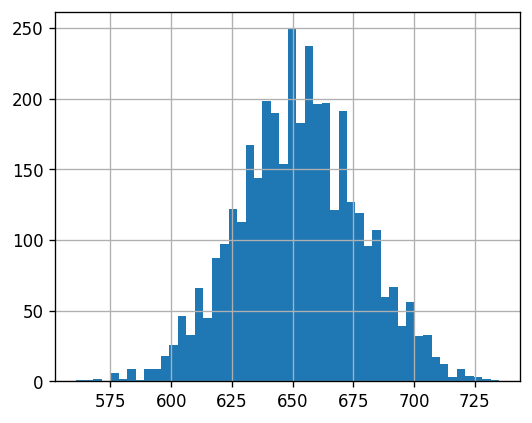

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize = (5, 4), dpi = 120)
plt.hist(transforms["train"][0].frequencies.cpu().numpy(), bins = 50)
plt.grid()


Now we can get the best model path stored in the checkpoint callback.

In [21]:
best_model_path = checkpoint_callback.best_model_path
best_model_path

'/home/nkulikov/RePlay/examples/sasrec/checkpoints/epoch=96-step=18333.ckpt'

## Inference

To obtain model scores, we will load the weights from the best checkpoint. To do this, we use the `LightningModule`, provide there the path to the checkpoint and the model instance.

In [22]:
import replay
torch.serialization.add_safe_globals([
    replay.nn.lightning.optimizer.OptimizerFactory,
    replay.nn.lightning.scheduler.LRSchedulerFactory
])

In [23]:
sasrec = make_sasrec(
    schema=tensor_schema,
    embedding_dim=EMBEDDING_DIM,
    max_sequence_length=MAX_SEQ_LEN,
    num_heads=NUM_HEADS,
    num_blocks=NUM_BLOCKS,
    dropout=DROPOUT,
)

best_model = LightningModule.load_from_checkpoint(best_model_path, model=sasrec)
best_model.eval();

Configure `ParquetModule` for inference

In [24]:
inference_metadata = {"predict": create_meta(shape=MAX_SEQ_LEN)}

parquet_module = ParquetModule(
    predict_path=PREDICT_PATH,
    batch_size=BATCH_SIZE,
    metadata=inference_metadata,
    transforms=transforms,
)

During inference, we can use `TopItemsCallback`. Such callback allows you to get scores for each user throughout the entire catalog and get recommendations in the form of ids of items with the highest score values.


Recommendations can be fetched in four formats: PySpark DataFrame, Pandas DataFrame, Polars DataFrame or raw PyTorch tensors. Each of the types corresponds a callback. In this example, we'll be using the `PandasTopItemsCallback`.

In [25]:
from replay.nn.lightning.callback import PandasTopItemsCallback

csv_logger = CSVLogger(save_dir="sasrec/logs/test", name="SasRec-example")

TOPK = [1, 5, 10, 20]

pandas_prediction_callback = PandasTopItemsCallback(
    top_k=max(TOPK),
    query_column="user_id",
    item_column="item_id",
    rating_column="score",
)

trainer = L.Trainer(callbacks=[pandas_prediction_callback], logger=csv_logger, inference_mode=True)
trainer.predict(best_model, datamodule=parquet_module, return_predictions=False)

pandas_res = pandas_prediction_callback.get_result()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [26]:
pandas_res

,user_id,item_id,score
0,0,486,6.457348
0,0,224,6.311622
0,0,210,6.299765
0,0,101,6.193144
0,0,2142,6.179489
...,...,...,...
6037,6039,84,10.029899
6037,6039,2634,9.860862
6037,6039,1490,9.738086
6037,6039,2633,9.715384


### Calculating metrics

*test_gt* is already encoded, so we can use it for computing metrics.

In [27]:
from replay.metrics import MAP, OfflineMetrics, Precision, Recall
from replay.metrics.torch_metrics_builder import metrics_to_df

In [28]:
result_metrics = OfflineMetrics(
    [Recall(TOPK), Precision(TOPK), MAP(TOPK)],
    query_column="user_id",
    rating_column="score",
)(pandas_res, test_gt.explode("item_id"))

In [29]:
metrics_to_df(result_metrics)

k,1,10,20,5
MAP,0.020371,0.061189,0.068575,0.051101
Precision,0.020371,0.018731,0.014790,0.022093
Recall,0.020371,0.187314,0.295793,0.110467


Let's call the `inverse_transform` encoder's function to get the final dataframe with recommendations

In [30]:
encoder.inverse_transform(pandas_res)

,user_id,item_id,score
0,2012,500,6.457348
0,2012,231,6.311622
0,2012,216,6.299765
0,2012,104,6.193144
0,2012,2335,6.179489
...,...,...,...
6037,5727,86,10.029899
6037,5727,2841,9.860862
6037,5727,1623,9.738086
6037,5727,2840,9.715384
